In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./data/cleaned_songs_syl.csv')
df = df.drop(columns=['Unnamed: 0','SName', 'Artist'])
df = df.dropna()

# Removing categories
df['Genres'] = df['Genres'].apply(lambda x:  list(set(x.lower().replace("/", ";").replace(" ", "").split(';'))))
counts = pd.DataFrame(df.Genres.values.tolist()).stack().value_counts()
def remove_small_genres(row, buffer=5000, counts=counts):
    n_list = list()
    for r in row:
        if counts[r]>buffer:
            n_list.append(r)
    if len(n_list) == 0:
        return np.nan
    n_list.sort()
    return n_list
df['Genres'] = df['Genres'].apply(lambda x:  remove_small_genres(x))
df = df.dropna()


In [3]:
df['Genres'] = df['Genres'].apply(lambda x:  ';'.join(x))
df = df.groupby("Genres").filter(lambda x: len(x) > 1)
df['Genres'] = df['Genres'].apply(lambda x:  x.split(';'))
print(len(df))

180118


In [4]:
train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["Genres"].values,
)

val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

In [5]:
terms = tf.ragged.constant(train_df["Genres"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'rock', 'pop', 'heavymetal', 'hiphop', 'indie', 'romântico', 'hardrock', 'rap', 'r&b', 'rockalternativo', 'blackmusic', 'dance', 'folk', 'country', 'punkrock', 'soulmusic', 'electronica', 'religioso', 'gospel', 'hardcore', 'trilhasonora', 'blues']


In [6]:
sample_label = train_df["Genres"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")


Original label: ['hardrock', 'rock']
Label-binarized representation: [[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [7]:
train_df["Lyric"].apply(lambda x: len(x.split(" "))).describe()


count    162106.000000
mean        487.586450
std         307.539143
min           4.000000
25%         290.000000
50%         413.000000
75%         589.000000
max        6615.000000
Name: Lyric, dtype: float64

In [8]:
max_seqlen = 100
batch_size = 256
padding_token = "<pad>"
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["Genres"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Lyric"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)


In [9]:
vocabulary = set()
train_df["Lyric"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

2836


In [10]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


In [11]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


In [15]:
from keras.utils.vis_utils import plot_model
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)


Epoch 1/20
634/634 [==============================] - 55s 84ms/step - loss: 0.2869 - binary_accuracy: 0.9109 - val_loss: 0.2399 - val_binary_accuracy: 0.9154
Epoch 2/20
634/634 [==============================] - 52s 82ms/step - loss: 0.2247 - binary_accuracy: 0.9180 - val_loss: 0.2293 - val_binary_accuracy: 0.9171
Epoch 3/20
634/634 [==============================] - 51s 80ms/step - loss: 0.2097 - binary_accuracy: 0.9213 - val_loss: 0.2286 - val_binary_accuracy: 0.9173
Epoch 4/20
634/634 [==============================] - 51s 81ms/step - loss: 0.1982 - binary_accuracy: 0.9246 - val_loss: 0.2295 - val_binary_accuracy: 0.9171
Epoch 5/20
634/634 [==============================] - 53s 83ms/step - loss: 0.1862 - binary_accuracy: 0.9283 - val_loss: 0.2352 - val_binary_accuracy: 0.9146
Epoch 6/20
634/634 [==============================] - 52s 82ms/step - loss: 0.1740 - binary_accuracy: 0.9323 - val_loss: 0.2455 - val_binary_accuracy: 0.9145
Epoch 7/20
634/634 [==============================] 

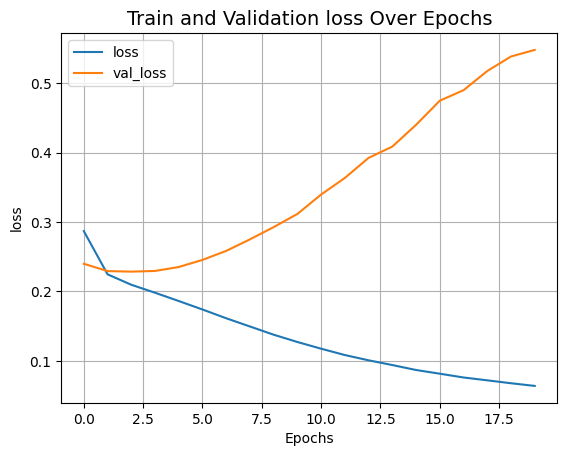

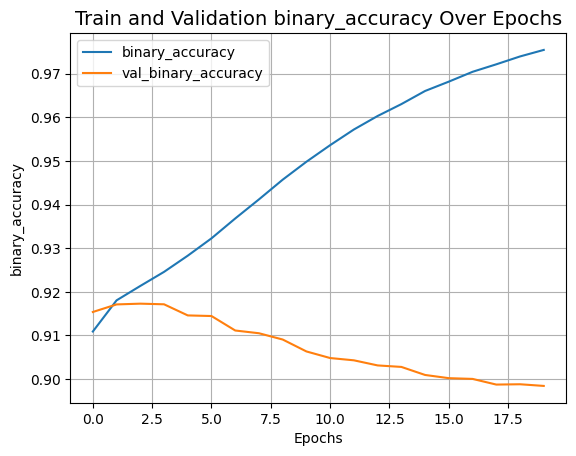

In [16]:
history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")


In [17]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

36/36 [==============================] - 1s 29ms/step - loss: 0.5516 - binary_accuracy: 0.8975
Categorical accuracy on the test set: 89.75%.


In [19]:
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 [==============================] - 0s 10ms/step
Abstract: b'wr it te nb yn ic kd ra ke re co rd ed by el to nj oh nb ut un re le as ed do nt yo uh av ea wo rd to sh ow wh at ma yb ed on eh av ey ou ne ve rh ea rd aw ay to fi nd th es un te ll me al lt ha ty ou ma yk no ws ho wm ew ha ty ou ha ve to sh ow wo nt yo uc om ea nd sa yi fy ou kn ow th ew ay to bl ue ha ve yo us ee nt he la nd li vi ng by th eb re ez ec an yo uu nd er st an da li gh ta mo ng th et re es te ll me al lt ha ty ou ma yk no ws ho wm ew ha ty ou ha ve to sh ow te ll us al lt od ay if yo uk no wt he wa yt ob lu el oo kt ho ug ht im ea nd fi nd yo ur rh ym et el lu sw ha ty ou fi nd we wi ll wa it at yo ur ga te ho pi ng li ke th eb li nd ca ny ou no wr ec al la ll th at yo uh av ek no wn wi ll yo un ev er fa ll wh en th el ig ht ha sf lo wn te ll me al lt ha ty ou ma yk no ws ho wm ew ha ty ou ha ve to sh ow wo nt yo uc om ea nd sa yi fy ou kn ow th ew ay to bl ue'
Label(s): ['rock' 'pop' 'romântico']
Predicted 

In [ ]:
model_for_inference.save('model2/')
